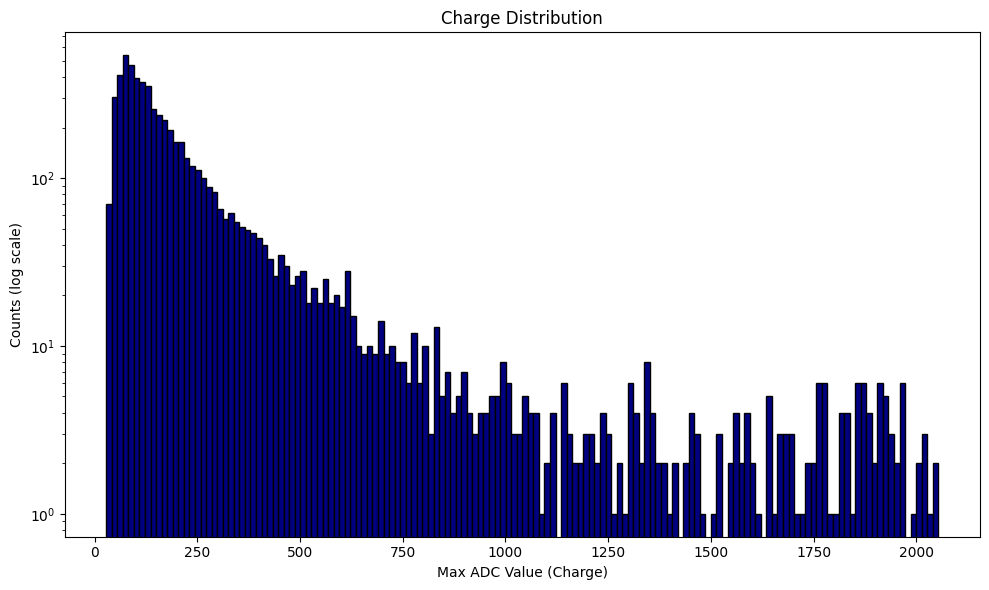

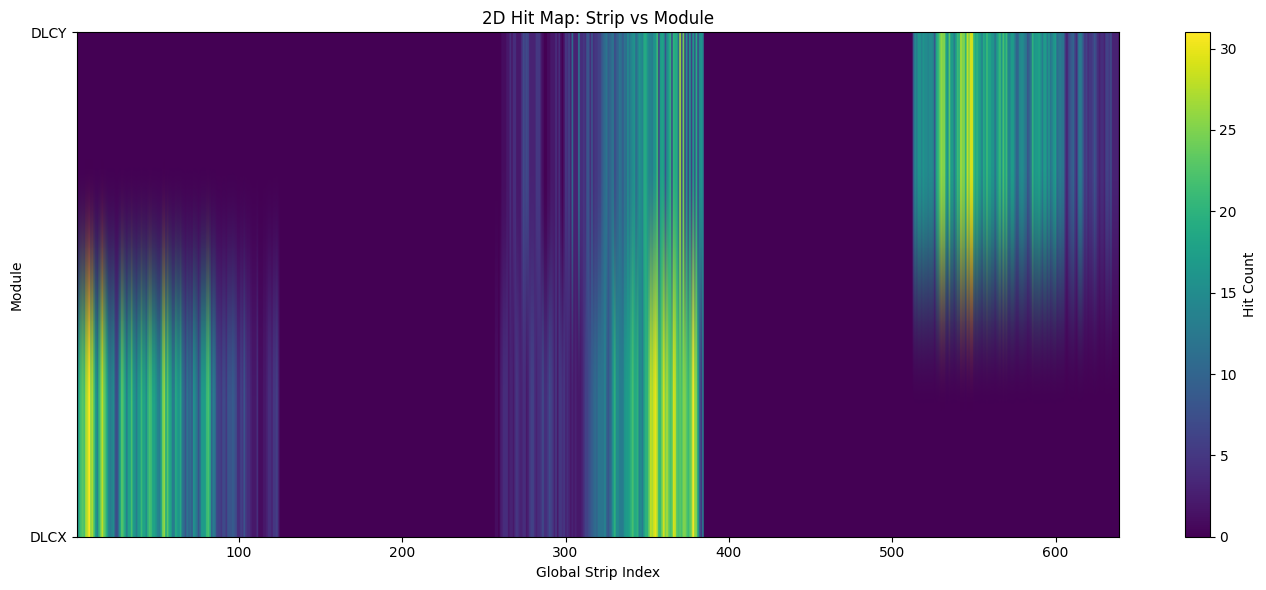

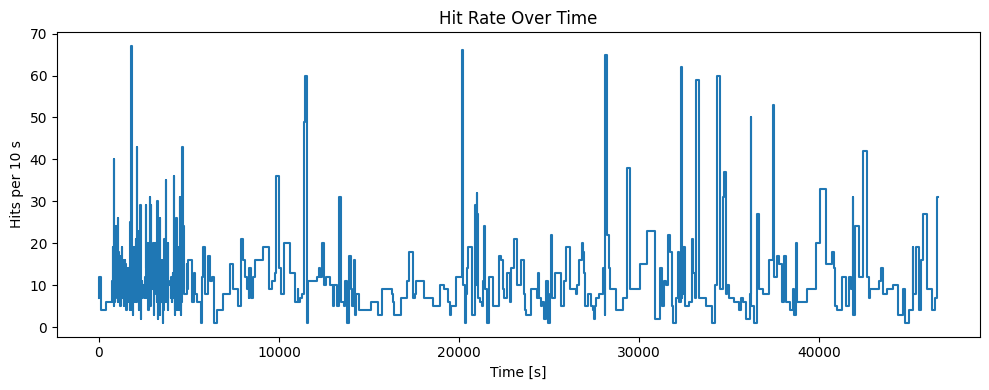

In [64]:
import uproot
import awkward as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === 1. Load ROOT File ===
file = uproot.open(r"C:\Users\syedm\Downloads\run10.root")
tree = file["raw"]
events = tree.arrays() #Use awkward arrays for efficient handling of jagged arrays meaning that each array can have varying lengths

# === 2. Extract max ADC (peak pulse) from waveforms ===
# apv_q is var * var * int16 → pulse shapes
apv_q_max = ak.max(events["apv_q"], axis=-1)  # max ADC per waveform because events["apv_q"] is shaped like [event][channel][samples] where channel essentially means the hit measurement strip

# === 3. Convert to flat dataframe ===
df = ak.to_dataframe({
    "apv_id": events["apv_id"], #each row then corresponds to one strip hip within an event , this tabular data would become easier to work with
    "mm_strip": events["mm_strip"],
    "mm_id": events["mm_id"],
    "apv_q": apv_q_max,
    "time_s": events["time_s"]
}).copy() 

# === 4. Clean and enforce types ===
df["apv_q"] = pd.to_numeric(df["apv_q"], errors="coerce")
df["mm_strip"] = pd.to_numeric(df["mm_strip"], errors="coerce")
df["apv_id"] = pd.to_numeric(df["apv_id"], errors="coerce")
df["time_s"] = pd.to_numeric(df["time_s"], errors="coerce")
df.dropna(inplace=True) #removes all rows with NaN
df = df[(df["apv_q"] > 0) & (df["apv_q"] < 4096) & (df["mm_strip"] >= 0)] #ADC > 4096 is beyond 12-bit ADC range so could be clipped or corrupted.

# === 5. Compute global strip index for 2D mapping ===
df["strip_global"] = df["apv_id"] * 128 + df["mm_strip"] #apv_id = 0 → strips 0–127, apv_id = 1 → 128–255
df["mm_id"] = df["mm_id"].astype(str)

# =============================
# === PLOT 1: Charge Distribution (Landau-like) ===
plt.figure(figsize=(10, 6))
plt.hist(df["apv_q"], bins = 150, color = "navy", edgecolor = "black", log = True) #log = true emphasizes the long tail in the distribution
plt.xlabel("Max ADC Value (Charge)")
plt.ylabel("Counts (log scale)")
plt.title("Charge Distribution")
plt.tight_layout()
plt.show()

# =============================
# === PLOT 2: 2D Hit Map (Global Strip vs Module ID) ===
# Map mm_id to integers for 2D plotting
mm_id_map = {v: i for i, v in enumerate(sorted(df["mm_id"].unique()))}
df["mm_id_index"] = df["mm_id"].map(mm_id_map)

# 2D histogram
strip_min = int(df["strip_global"].min())
strip_max = int(df["strip_global"].max())
mmid_min = int(df["mm_id_index"].min())
mmid_max = int(df["mm_id_index"].max())

H, _, _ = np.histogram2d(
    df["strip_global"], df["mm_id_index"],
    bins=[strip_max - strip_min + 1, mmid_max - mmid_min + 1],
    range=[[strip_min - 0.5, strip_max + 0.5], [mmid_min - 0.5, mmid_max + 0.5]]
)

plt.figure(figsize=(14, 6))
plt.imshow(H.T, origin='lower', aspect='auto', cmap='viridis',
           extent=[strip_min, strip_max, mmid_min, mmid_max])
plt.colorbar(label="Hit Count")
plt.xlabel("Global Strip Index")
plt.ylabel("Module")
plt.yticks(
    ticks=list(mm_id_map.values()),
    labels=list(mm_id_map.keys())
)
plt.title("2D Hit Map: Strip vs Module")
plt.tight_layout()
plt.show()


# =============================
# === PLOT 3: Hit Rate Over Time ===
if df["time_s"].notna().any():
    df["time_offset"] = df["time_s"] - df["time_s"].min()
    df["time_bin"] = (df["time_offset"] // 10).astype(int)
    hit_rate = df.groupby("time_bin")["apv_q"].count()

    plt.figure(figsize=(10, 4))
    plt.plot(hit_rate.index * 10, hit_rate.values, drawstyle='steps-mid')
    plt.xlabel("Time [s]")
    plt.ylabel("Hits per 10 s")
    plt.title("Hit Rate Over Time")
    plt.tight_layout()
    plt.show()
